### Generative model, and sampling from it

We start by creating an instance of our prior and likelihood models.

In [2]:
# Given
# -----
# N : integer, number of neurons.
# K : integer, number of trials.
# C : integer, number of stimulus conditions.
# seed : integer, random seed for reproducibility.
# sigma_m : float, prior kernel smoothness.

# Create instances of prior and likelihood distributions and generate some synthetic data.
import sys
import jax
from numpyro import optim
jax.config.update('jax_enable_x64', True)  # Use float64
jax.config.update("jax_default_matmul_precision", "highest")
# sys.path.append('wishart-process')
import inference
import models
import visualizations
import evaluation
import utils

import jax.numpy as jnp
import numpyro


import itertools
from tqdm import tqdm
import numpy as np
from scipy.io import loadmat

In [3]:
#import data

import matplotlib.pyplot as plt
# HUNGRY_DECONV = np.load('../../Data/predictions_fullTrace_hungry.npy', allow_pickle=True)
HUNGRY_DECONV = np.load('../Data/predictions_fullTrace_hungry.npy', allow_pickle=True)

print(HUNGRY_DECONV.shape)

FOOD_RESTRICTED_HUNGRY = [1,2,3,6,7,9,11,12]
CONTROL_HUNGRY = [0,4,5,8,10,13]


# AngStim_data = '../../Data/metadata_deconv/stimAngle_hungry.mat'
AngStim_data = '../Data/metadata_deconv/stimAngle_hungry.mat'

ANG_STIM_DATA = loadmat(AngStim_data, simplify_cells= True)
HUNGRY_ANGLE = ANG_STIM_DATA['order_of_stim_arossAnimals']
print(HUNGRY_ANGLE[0].shape)

# SfStim_data = '../../Data/metadata_deconv/stimSpatFreq_hungry.mat'
SfStim_data = '../Data/metadata_deconv/stimSpatFreq_hungry.mat'

SF_STIM_DATA = loadmat(SfStim_data, simplify_cells= True)
HUNGRY_SF = SF_STIM_DATA['stimSpatFreq_arossAnimals']
print(HUNGRY_SF[0].shape)

def resort_preprocessing(datum,angle_arr,sf_arr,animal):
    data = np.copy(datum[animal,:])
    neurons = data[0].shape[0]
    reshape_data = np.full((60,neurons,data[0].shape[1]), np.nan)
    for i in range(60):
        reshape_data[i,:,:] = data[i]

    reshape_data = reshape_data.reshape(60,neurons,12,120)
    reshape_data = np.transpose(reshape_data,(1,2,0,3))
    #Remove first two neurons
    reshape_data = reshape_data[2:,:,:,:]

    #Remove None trials
    max_trial = np.argmax(np.isnan(reshape_data[0,1,:,0]))
    reshape_data = reshape_data[:,:,:max_trial,:]

    # Remove beginning and last bit # HMMMM should I do this?
    # reshape_data[:,0,:,:32] = np.nan
    # reshape_data[:,-1,:,88:] = np.nan
    # print(np.any(np.isnan(reshape_data)))
    # print(reshape_data.shape)
    
    # Reorder angles
    angles = np.copy(angle_arr[animal])
    for itrials in range(angles.shape[1]):
        order = angles[:,itrials]-1
        reshape_data[:,:,itrials,:] = reshape_data[:,order,itrials,:]

    # Reorder SFs
    reshaped_data = []
    sfs = np.copy(sf_arr[animal])
    for experiment in range(1,6):
        mask = sfs == experiment
        reshaped_data.append(reshape_data[:,:,mask,:])

    max_trials = max([exp.shape[2] for exp in reshaped_data])
    # Pad the data for experiments with (10, 12, 80)fewer trials
    for i in range(len(reshaped_data)):
        if reshaped_data[i].shape[2] < max_trials:
            padding = max_trials - reshaped_data[i].shape[2]
            reshaped_data[i] = np.pad(reshaped_data[i], ((0, 0),(0, 0),(0, padding),(0, 0)), mode='constant', constant_values=np.nan)

    reshaped_data = np.stack(reshaped_data,axis=2)    

    return reshaped_data
x = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)
print(np.sum(np.isnan(x)))




def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered



(14, 60)
(12, 55)
(55,)
450560


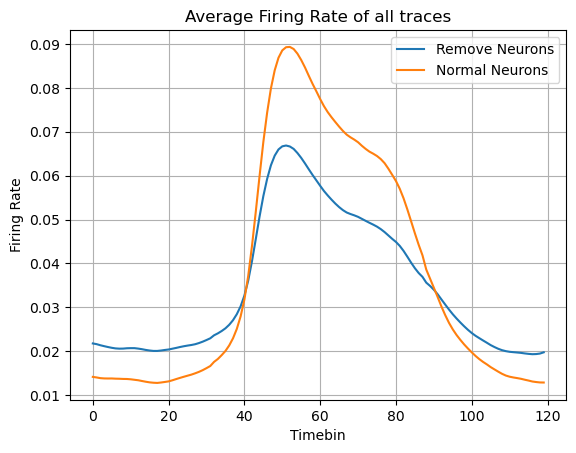

In [3]:
remove_mean = np.zeros((14,120))
normal_mean = np.zeros((14,120))
for i in range(14):
    remove_mean[i,:] = np.nanmean(resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,i)[:,4,:,:,:],axis = (0,1,2))
    normal_mean[i,:] = np.nanmean(remove_neurons(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,i)[:,4,:,:,:],axis = (0,1,2))
plt.plot(np.mean(remove_mean,axis=0), label = 'Remove Neurons')
plt.plot(np.mean(normal_mean,axis=0), label = 'Normal Neurons')
plt.xlabel('Timebin')
plt.ylabel('Firing Rate')
plt.title('Average Firing Rate of all traces')
plt.legend()
plt.grid()

In [4]:
TEST_DATA = resort_preprocessing(HUNGRY_DECONV,HUNGRY_ANGLE,HUNGRY_SF,0)[:,:,0,:,40:80]
# Animal = 0, SF = 0 and during response
TEST_RESPONSE = jnp.nanmean(TEST_DATA,axis = -1) # Shape N x C x K 
TEST_RESPONSE = jnp.transpose(TEST_RESPONSE, (2,1,0)) # Shape K X C X N
print(TEST_RESPONSE.shape)
N = TEST_RESPONSE.shape[2]
C = TEST_RESPONSE.shape[1]
K = TEST_RESPONSE.shape[0]
SEED = 1
PERIOD = C
X_CONDITIONS = jnp.linspace(0,C-1,C)

# keep only trials that have at least one finite value
good_trials = ~jnp.isnan(TEST_RESPONSE).all(axis=(1, 2))   # shape (K,)
TEST_RESPONSE = TEST_RESPONSE[good_trials]                 # (K′, C, N)
K = TEST_RESPONSE.shape[0]
print(f"{K} good trials remain")


# Z-score test response along the trial axis
# TEST_RESPONSE = (TEST_RESPONSE - jnp.nanmean(TEST_RESPONSE, axis=0)) / jnp.nanstd(TEST_RESPONSE, axis=0)


(11, 12, 128)
11 good trials remain


In [5]:
hyperparams = {
    'sigma_m':2.4886496,
    'gamma_gp': 0.00016234,
    'beta_gp': 0.24385944,
    'sigma_c': 0.28382865,
    'gamma_wp':0.00044405,
    'beta_wp':1.0398238,
    'p': 0,
}

In [6]:
# Initialise Kernel and Model
periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['sigma_m']))
periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(hyperparams['sigma_c']))

In [7]:

# Prior distribution (GP and WP)
gp = models.GaussianProcess(kernel=periodic_kernel_gp,N=N)
# wp = models.WishartProcess(kernel =periodic_kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
wp = models.WishartLRDProcess(kernel=periodic_kernel_wp,P=hyperparams['p'],V=1e-2*jnp.eye(N), optimize_L=False)
likelihood = models.NormalConditionalLikelihood(N)

Now we are ready to fit the model to data and infer posterior distributions over neural means and covariances. Then we can sample from the inferred posterior and compute their likelihoods.

In [8]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

# Joint distribution
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
inference_seed = 2
varfam = inference.VariationalNormal(joint.model)
adam = optim.Adam(1e-1)
key = jax.random.PRNGKey(inference_seed)

varfam.infer(adam,X_CONDITIONS,TEST_RESPONSE,n_iter = 2000,key=key)
joint.update_params(varfam.posterior)
posterior = models.NormalGaussianWishartPosterior(joint, varfam, X_CONDITIONS)

/home/scastedo/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/2000 [00:00<?, ?it/s]/home/scastedo/miniforge3/envs/wishart/lib/python3.13/site-packages/jax/_src/linear_util.py:370: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = _fun(*args, **kwargs)
100%|██████████| 2000/2000 [00:12<00:00, 161.86it/s, init loss: 28377043.4027, avg. loss [1901-2000]: -14619.1524]


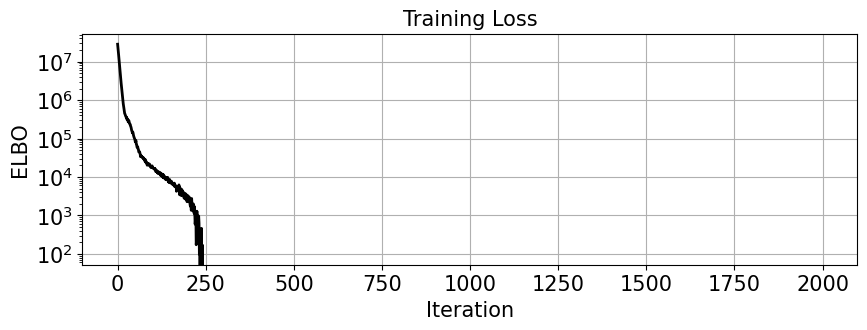

In [9]:
# %% Visualization
visualizations.plot_loss(
    [varfam.losses],xlabel='Iteration',ylabel='ELBO',titlestr='Training Loss',colors=['k'],
)

We can sample from the inferred posterior, compute likelihoods and summary statistics, evaluate its mode, compute derivatives, and more.

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


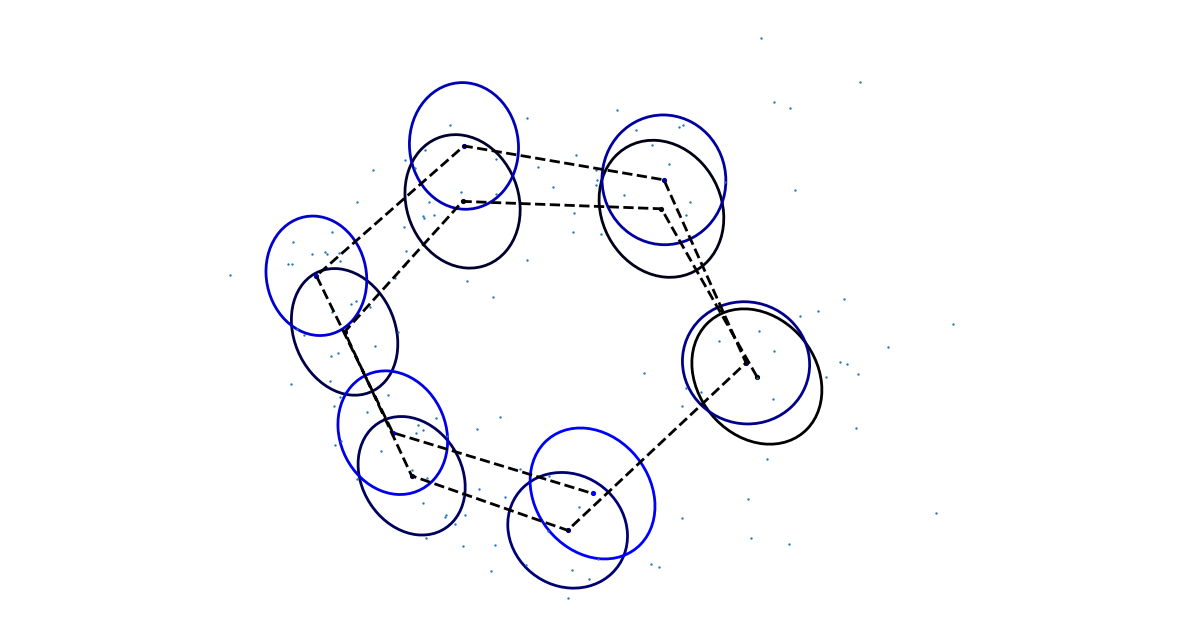

In [10]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,X_CONDITIONS)

# Sample from the posterior
with numpyro.handlers.seed(rng_seed=inference_seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)

visualizations.visualize_pc(
    mu_hat[:,None],sigma_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)


Posterior mean shape: (12, 128)
Posterior covariance shape: (12, 128, 128)


Text(0, 0.5, 'Mean Overlap')

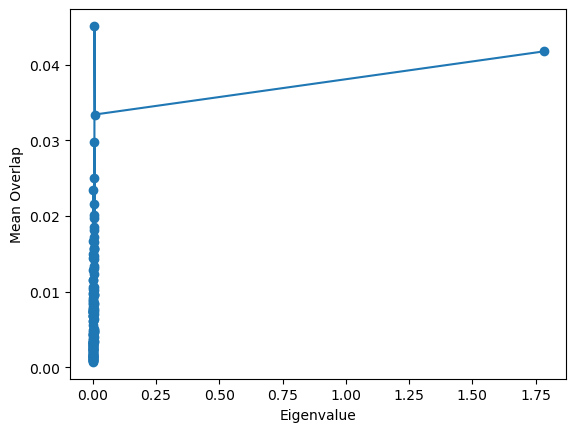

In [12]:
print("Posterior mean shape:", mu_hat.shape)
print("Posterior covariance shape:", sigma_hat.shape)
num_angles = mu_hat.shape[0]
num_evec = sigma_hat.shape[1]
overlaps = np.zeros((num_angles, num_evec))
eig_vals = np.zeros((num_angles, num_evec))
for i in range(num_angles):
    eval, evec = np.linalg.eigh(sigma_hat[i,:,:])
    # evec = evec[:,::-1]  # Sort eigenvectors by eigenvalues in descending order
    # eval = eval[::-1]  # Sort eigenvalues in descending order
    eig_vals[i,:] = eval
    d_mu = mu_hat[i,:] - mu_hat[(i+1)%num_angles,:]
    for j in range(num_evec):
        square_overlap = np.abs(np.dot(d_mu, evec[:,j])**2 / (np.linalg.norm(d_mu)**2 * np.linalg.norm(evec[:,j])**2))
        overlaps[i,j] = square_overlap
mean_overlap = np.mean(overlaps, axis=0)
mean_evals = np.mean(eig_vals, axis=0)
plt.plot(mean_evals,mean_overlap, marker='o')
# for i in range(num_angles):
    # plt.plot(eig_vals[i,:],overlaps[i,:], marker='o', label=f'Angle {i+1}')
plt.xlabel('Eigenvalue')
plt.ylabel('Mean Overlap')


# Hyper Param Tuning

In [ ]:
def evaluate_hyperparameters(hyperparams, x_train, y_train, x_test, y_test, n_iter=5000):

    # Initialize kernels with the hyperparameters
    periodic_kernel_gp = lambda x, y: hyperparams['gamma_gp']*(x==y) + hyperparams['beta_gp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_m']**2))
    periodic_kernel_wp = lambda x, y: hyperparams['gamma_wp']*(x==y) + hyperparams['beta_wp']*jnp.exp(-jnp.sin(jnp.pi*jnp.abs(x-y)/PERIOD)**2/(2*hyperparams['sigma_c']**2))
    
    # Set up the model
    gp = models.GaussianProcess(kernel=periodic_kernel_gp, N=N)
    wp = models.WishartProcess(kernel=periodic_kernel_wp, P=hyperparams['p'], V=1e-2*jnp.eye(N), optimize_L=False)
    likelihood = models.NormalConditionalLikelihood(N)
    joint = models.JointGaussianWishartProcess(gp, wp, likelihood)
    
    # Set up variational inference
    inference_seed = 2
    key = jax.random.PRNGKey(inference_seed)
    varfam = inference.VariationalNormal(joint.model)
    adam = optim.Adam(1e-1)
    
    # Train the model
    varfam.infer(adam, x_train, y_train, n_iter=n_iter, key=key)
    joint.update_params(varfam.posterior)
    
    posterior = models.NormalGaussianWishartPosterior(joint,varfam,x_train)
    with numpyro.handlers.seed(rng_seed=inference_seed):
        mu_hat, sigma_hat, F_hat = posterior.sample(x_train)
    mu_empirical = y_train.mean(0)
    log_likelihood = likelihood.log_prob(y_test['x'], mu_empirical, sigma_hat).flatten()

    # # Create posterior and compute log likelihood on validation data
    # posterior = models.NormalGaussianWishartPosterior(joint, varfam, x_train)
    # Compute log likelihood (directly using the posterior's log_prob method)
    # This uses x_val and y_val_data
    # log_likelihood = posterior.log_prob(x_test, y_test['x'])

    return log_likelihood.mean()

def optimize_hyperparameters(x_train, y_train, x_val, y_val, hyperparam_grid, n_iter=5000):
    
    # Generate all combinations of hyperparameters
    keys = list(hyperparam_grid.keys())
    values = list(hyperparam_grid.values())
    hyperparameter_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]
    
        
    best_score = float('-inf')  # For log-likelihood, higher is better
    best_hyperparams = None
    
    for i, hyperparams in enumerate(tqdm(hyperparameter_combinations)):
        try:
            print(f"\nEvaluating hyperparameters {i+1}/{len(hyperparameter_combinations)}:")
            score = evaluate_hyperparameters(hyperparams, x_train, y_train, x_val, y_val, n_iter)
            
            print(f"Score: {score}")
            
            # Update best if needed
            if score > best_score:
                best_score = score
                best_hyperparams = hyperparams
                print(f"New best score: {best_score}")
                
        except Exception as e:
            print(f"Error with hyperparams {hyperparams}: {str(e)}")
            continue
    
    return best_hyperparams, best_score

# Main execution
if __name__ == "__main__":
    # Split data
    data = utils.split_data(x=X_CONDITIONS[:, None], y=TEST_RESPONSE, 
                           train_trial_prop=0.8, train_condition_prop=0.8, seed=SEED)
    x_train, y_train, _, _, x_test, y_test, _, _, _, _, _, _, _, _ = data
    
    print('x conditions train ', x_train.shape)     # x_train 80% of conditions: 9/12

    print('y data train ', y_train.shape)     # ytrain 80% conditions and trials : 9/12, 8/11

    print('x conditions val ', x_test.shape)     # x_test 20% of conditions: 3/12

    print('y_val, (x) ', y_test['x'].shape)     # y_test['x'] 20% of trials and 80% conditions: 9/12, 3/11

    print('y_val, (x_test) ', y_test['x_test'].shape)     # y_test['x_test'] 100% of trials and 20% conditions: 3/12, 11/11
    x_train = x_train.reshape(x_train.shape[0])
    x_test = x_test.reshape(x_test.shape[0])

    # Define a more focused hyperparameter grid
    hyperparam_grid = {
        'sigma_m': [0.1,0.2,0.3,0.4, 0.5,0.6,0.7, 1.0,5],
        'gamma_gp': [1e-6,1e-5,1e-4,1e-3],
        'beta_gp': [1e-1,1,1e1,1e2],
        'sigma_c': [0.1,0.2,0.3,0.4, 0.5,0.6,0.7, 1.0,5],
        'gamma_wp': [1e-6,1e-5,1e-4,1e-3],
        'beta_wp': [1e-1,1,1e1,1e2],
        'p': [N+1]
    }
    hyperparam_grid = {
    'sigma_m': [0.5,1,2],
    'gamma_gp': [1e-6],
    'beta_gp': [1e-1],
    'sigma_c': [0.5,1],
    'gamma_wp': [1e-6],
    'beta_wp': [1e-1,1],
    'p': [N+1]
    }
    
    # Run optimization with a time budget of 12 hours
    best_hyperparams, best_score = optimize_hyperparameters(
        x_train, y_train, x_test, y_test, 
        hyperparam_grid, 
        n_iter=400)
    
    print("\n=== Optimization Results ===")
    print(f"Best hyperparameters:")
    for k, v in best_hyperparams.items():
        print(f"  {k}: {v}")
    print(f"Best score: {best_score}")

# Compare to Empirical

(12, 128)


/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


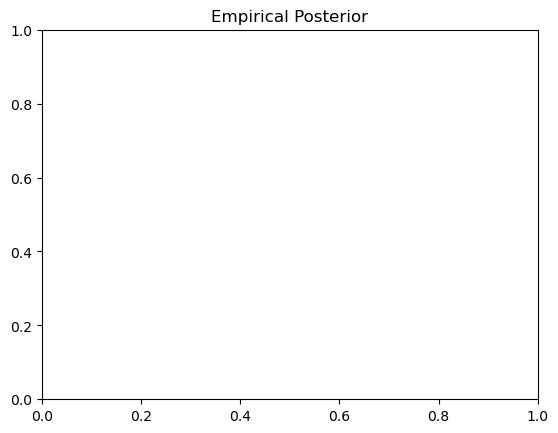

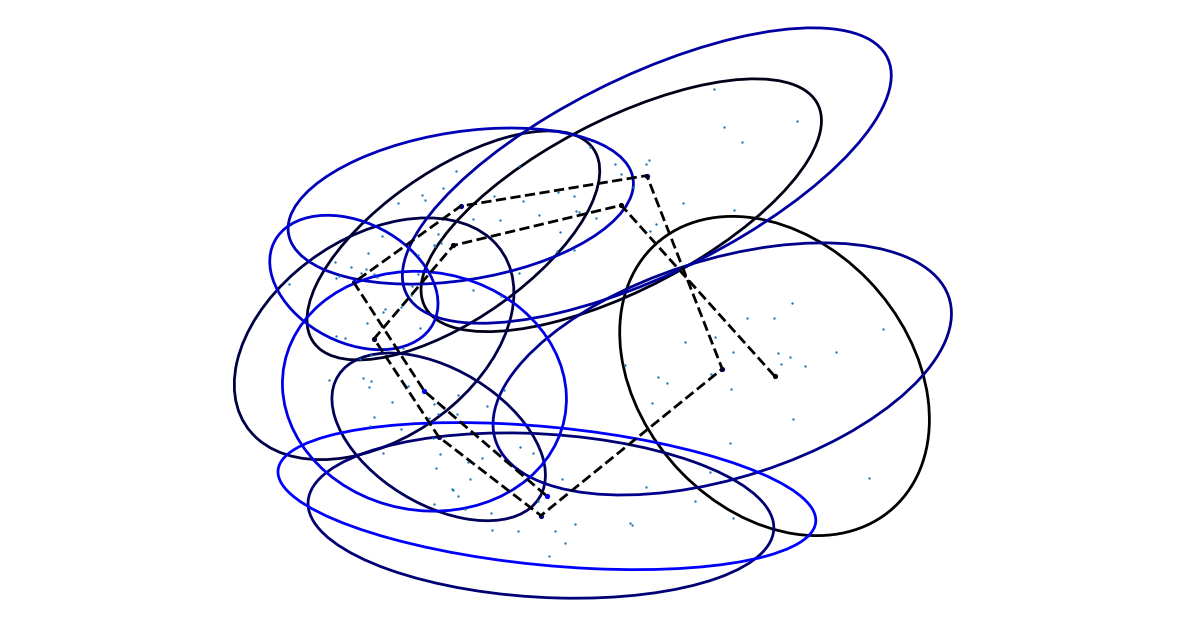

In [ ]:
import pandas as pd
empirical_mu = jnp.nanmean(TEST_RESPONSE,axis=0)
print(empirical_mu.shape)
# empirical_cov =jnp.cov(TEST_RESPONSE,axis=0)
empirical_sigma = jnp.zeros((C, N, N))
for i in range(C):
    dat = TEST_RESPONSE[:,i,:] # Shape K x N
    df = pd.DataFrame(dat)
    covariances = df.cov().to_numpy()
    covariances += np.eye(N) * 1e-6
    empirical_sigma = empirical_sigma.at[i].set(covariances)
visualizations.visualize_pc(
    empirical_mu[:,None],empirical_sigma,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
)



# Test Unseen conditions 

/home/scastedo/wishart-process/visualizations.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


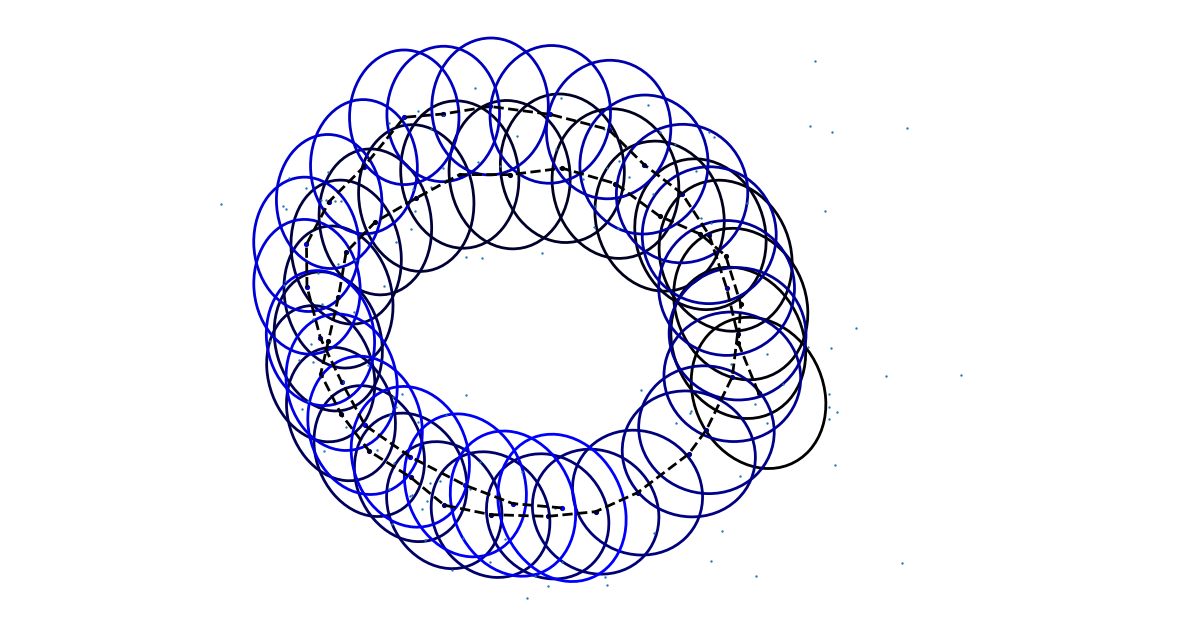

In [11]:

with numpyro.handlers.seed(rng_seed=1):
    X_TEST_CONDITIONS = jnp.linspace(0, C-1, 48)
    mu_test_hat, sigma_test_hat, F_test_hat = posterior.sample(X_TEST_CONDITIONS)
    #does sigma_test_hat have nans, if so remove?
    if jnp.all(jnp.isnan(mu_test_hat)):
        print("sigma_test_hat has nans")
        sigma_test_hat = jnp.nan_to_num(sigma_test_hat)
    sigma_test_hat = jnp.where(jnp.isnan(sigma_test_hat), 0, sigma_test_hat)
    
    visualizations.visualize_pc(
        mu_test_hat[:,None],sigma_test_hat,pc=TEST_RESPONSE.reshape(TEST_RESPONSE.shape[0]*TEST_RESPONSE.shape[1],-1)
    )


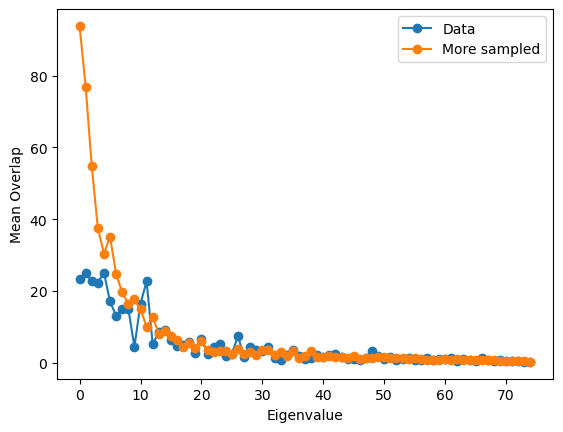

In [19]:
num_angles = mu_test_hat.shape[0]
num_evec = sigma_test_hat.shape[1]
overlaps = np.zeros((num_angles, num_evec))
eig_vals = np.zeros((num_angles, num_evec))
for i in range(num_angles):
    eval, evec = np.linalg.eigh(sigma_test_hat[i,:,:])
    # evec = evec[:,::-1]  # Sort eigenvectors by eigenvalues in descending order
    # eval = eval[::-1]  # Sort eigenvalues in descending order
    eig_vals[i,:] = eval
    d_mu = mu_test_hat[i,:] - mu_test_hat[(i+1)%num_angles,:]
    for j in range(num_evec):
        square_overlap = np.abs(np.dot(d_mu, evec[:,j])**2 / (np.linalg.norm(d_mu)**2 * np.linalg.norm(evec[:,j])**2))
        overlaps[i,j] = square_overlap
mean_overlap2 = np.mean(overlaps, axis=0)
mean_evals2 = np.mean(eig_vals, axis=0)
# plt.plot(mean_evals,mean_overlap, marker='o', label='Data')
# plt.plot(mean_evals2,mean_overlap2, marker='o', label='More sampled')


plt.plot(mean_overlap/mean_evals, marker='o', label='Data')
plt.plot(mean_overlap2/mean_evals2, marker='o', label='More sampled')


plt.xlabel('Eigenvalue')
plt.ylabel('Mean Overlap')
plt.legend()




# FISHER INFORMATION

In [ ]:
with numpyro.handlers.seed(rng_seed=1):

    mu_hat, sigma_hat, F_hat = posterior.sample(X_CONDITIONS)
    mu_prime, sigma_prime = posterior.derivative(X_CONDITIONS)

    # Compute Fisher Information
    fi = evaluation.fisher_information(X_CONDITIONS,mu_prime,sigma_hat,sigma_prime)
    print(fi.shape)
    print(fi)


def remove_neurons(datum, angles,sfs, animal, count = False):
    neurons_to_keep = []
    data = resort_preprocessing(datum,angles,sfs,animal)
    number_neurons = data.shape[0]    
    for i in range(number_neurons):
        # print(np.nanmean(data[i, :, :, :, 40:80], axis = 3))
        stim_average = np.mean(data[i, :, :, :, 40:80], axis = 3) # OKAY TO NOT HAVE NANMEAN?
        best_sf = np.argmax(np.nanmean(stim_average, axis = (0,2))).astype('int')
        best_angle = np.argmax(np.nanmean(stim_average[:,best_sf,:], axis = 1)).astype('int')
        averaged_calcium = np.nanmean(stim_average[best_angle,best_sf,:])
        
        grey_data = data[i, :, :, :, 0:20]
        # grey_data = np.concatenate((data[i, :, :, :, 0:40], data[i, :, :, :, 80:]), axis = 3)
        grey_average = np.mean(grey_data, axis = 3)
        best_sf = np.argmax(np.nanmean(grey_average, axis = (0,2))).astype(int)
        best_angle = np.argmax(np.nanmean(grey_average[:,best_sf,:], axis = 1)).astype(int)
        average_grey = np.nanmean(grey_average[best_angle,best_sf,:])
        std_grey = np.nanstd(grey_average[best_angle,best_sf,:])
        
        if np.abs(averaged_calcium - average_grey) >= 1.69*std_grey:
            neurons_to_keep.append(i)
    
    # Keep only the neurons that meet the condition
    data_filtered = data[neurons_to_keep, :, :,:,:]
    if count:
        return data_filtered.shape[0]/data.shape[0]

    return data_filtered

In [26]:
ctr_fisher = np.load('ctr_fisher_info.npy', allow_pickle=True)
fr_fisher = np.load('fr_fisher_info.npy', allow_pickle=True)

Mann-Whitney U statistic: 19.0, p-value: 0.5727605727605728


/tmp/ipykernel_247113/4221620351.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([ctr_fisher_per_animal, fr_fisher_per_animal], labels=['Control', 'Food Restricted'])


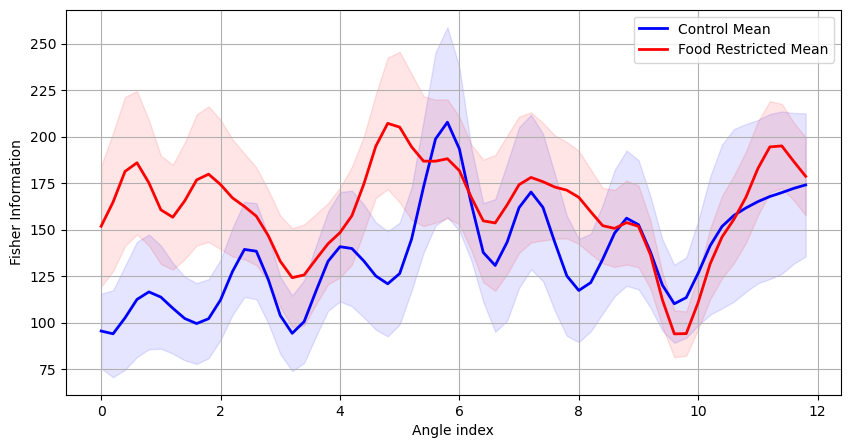

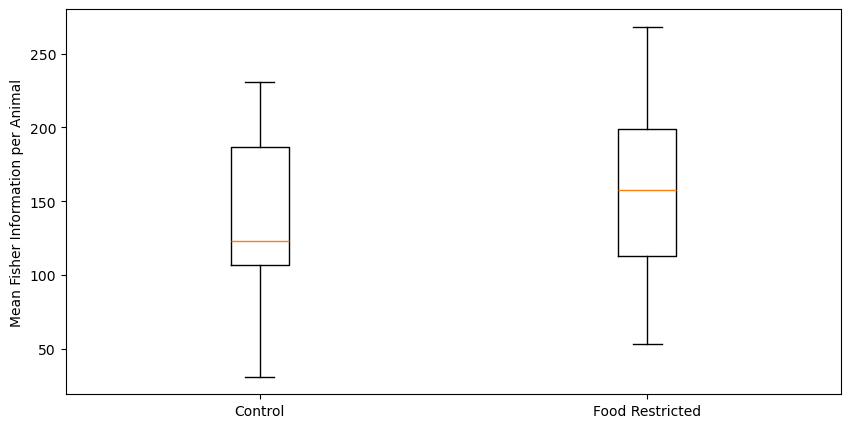

In [39]:
plt.figure(figsize=(10, 5))
# Average over the first index (animals), so shape becomes (n_angles,)

ctr_fisher_mean = np.mean(ctr_fisher, axis=0)
fr_fisher_mean = np.mean(fr_fisher, axis=0)
angles = np.arange(0, 12, 12/60)

# Plot for each animal
# for i in range(ctr_fisher.shape[0]):
#     plt.plot(angles, ctr_fisher[i], color='blue', alpha=0.3)
# for i in range(fr_fisher.shape[0]):
#     plt.plot(angles, fr_fisher[i], color='red', alpha=0.3)

# Plot mean
plt.plot(angles, ctr_fisher_mean, label='Control Mean', color='blue', linewidth=2)
plt.fill_between(
    angles,
    ctr_fisher_mean - np.std(ctr_fisher, axis=0) / np.sqrt(ctr_fisher.shape[0]),
    ctr_fisher_mean + np.std(ctr_fisher, axis=0) / np.sqrt(ctr_fisher.shape[0]),
    color='blue', alpha=0.1
)
plt.plot(angles, fr_fisher_mean, label='Food Restricted Mean', color='red', linewidth=2)
plt.fill_between(
    angles,
    fr_fisher_mean - np.std(fr_fisher, axis=0) / np.sqrt(fr_fisher.shape[0]),
    fr_fisher_mean + np.std(fr_fisher, axis=0) / np.sqrt(fr_fisher.shape[0]),
    color='red', alpha=0.1
)

plt.xlabel('Angle index')
plt.ylabel('Fisher Information')
plt.legend()
plt.grid()

plt.figure(figsize=(10, 5))
# Box plot: each box is the mean Fisher info per animal
ctr_fisher_per_animal = np.mean(ctr_fisher, axis=1)
fr_fisher_per_animal = np.mean(fr_fisher, axis=1)
plt.boxplot([ctr_fisher_per_animal, fr_fisher_per_animal], labels=['Control', 'Food Restricted'])
plt.ylabel('Mean Fisher Information per Animal')

from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(ctr_fisher_per_animal, fr_fisher_per_animal)
print(f'Mann-Whitney U statistic: {u_stat}, p-value: {p_value}')

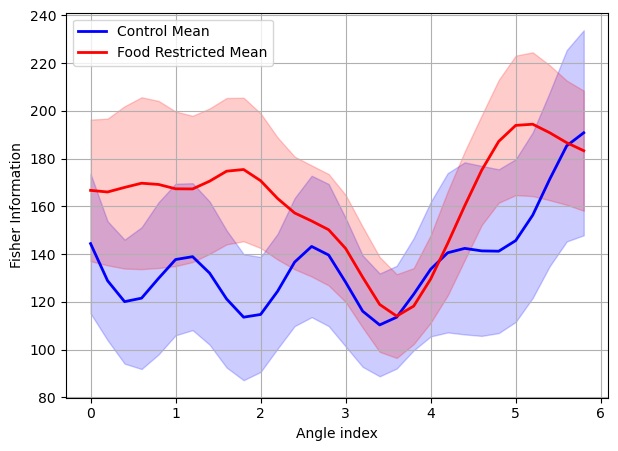

In [36]:
ctr_fisher_folded = np.zeros((ctr_fisher.shape[0], ctr_fisher.shape[1]//2))
fr_fisher_folded = np.zeros((fr_fisher.shape[0], fr_fisher.shape[1]//2))

for i in range(ctr_fisher.shape[1]//2):
    ctr_fisher_folded[:,i] = (ctr_fisher[:,i] + ctr_fisher[:,ctr_fisher.shape[1]//2+i])/2
    fr_fisher_folded[:,i] = (fr_fisher[:,i] + fr_fisher[:,ctr_fisher.shape[1]//2+i])/2


plt.figure(figsize=(7, 5))
# Average over the first index (animals), so shape becomes (n_angles,)
ctr_fisher_mean = np.mean(ctr_fisher_folded, axis=0)
fr_fisher_mean = np.mean(fr_fisher_folded, axis=0)
angles = np.arange(0, 6, 6/30)
# Plot for each animal
# for i in range(ctr_fisher_folded.shape[0]):
#     plt.plot(angles, ctr_fisher_folded[i], color='blue', alpha=0.3)
 
# for i in range(fr_fisher_folded.shape[0]):
#     plt.plot(angles, fr_fisher_folded[i], color='red', alpha=0.3)

# Plot mean
plt.plot(angles, ctr_fisher_mean, label='Control Mean', color='blue', linewidth=2)
plt.fill_between(
    angles,
    ctr_fisher_mean - np.std(ctr_fisher_folded, axis=0) / np.sqrt(ctr_fisher_folded.shape[0]),
    ctr_fisher_mean + np.std(ctr_fisher_folded, axis=0) / np.sqrt(ctr_fisher_folded.shape[0]),
    color='blue', alpha=0.2
)
plt.plot(angles, fr_fisher_mean, label='Food Restricted Mean', color='red', linewidth=2)
plt.fill_between(
    angles,
    fr_fisher_mean - np.std(fr_fisher_folded, axis=0) / np.sqrt(fr_fisher_folded.shape[0]),
    fr_fisher_mean + np.std(fr_fisher_folded, axis=0) / np.sqrt(fr_fisher_folded.shape[0]),
    color='red', alpha=0.2
)
plt.xlabel('Angle index')
plt.ylabel('Fisher Information')
plt.legend()
plt.grid()
plt.show()

overlaps_fr_normal shape: (8, 12, 5, 30)
eigs_fr_normal shape: (8, 12, 5, 30)
total_snr fr: 34.686725381562844
total_snr fr super: 4.116107017192779
total_snr ctr: 33.37820495701152
total_snr ctr super: 4.427886539372044


(array([0.0003  , 0.000325, 0.00035 , 0.000375, 0.0004  , 0.000425,
        0.00045 , 0.000475, 0.0005  , 0.000525, 0.00055 ]),
 [Text(0, 0.00030000000000000003, '0.000300'),
  Text(0, 0.00032500000000000004, '0.000325'),
  Text(0, 0.00035000000000000005, '0.000350'),
  Text(0, 0.000375, '0.000375'),
  Text(0, 0.0004, '0.000400'),
  Text(0, 0.00042500000000000003, '0.000425'),
  Text(0, 0.00045000000000000004, '0.000450'),
  Text(0, 0.00047500000000000005, '0.000475'),
  Text(0, 0.0005, '0.000500'),
  Text(0, 0.0005250000000000001, '0.000525'),
  Text(0, 0.00055, '0.000550')])

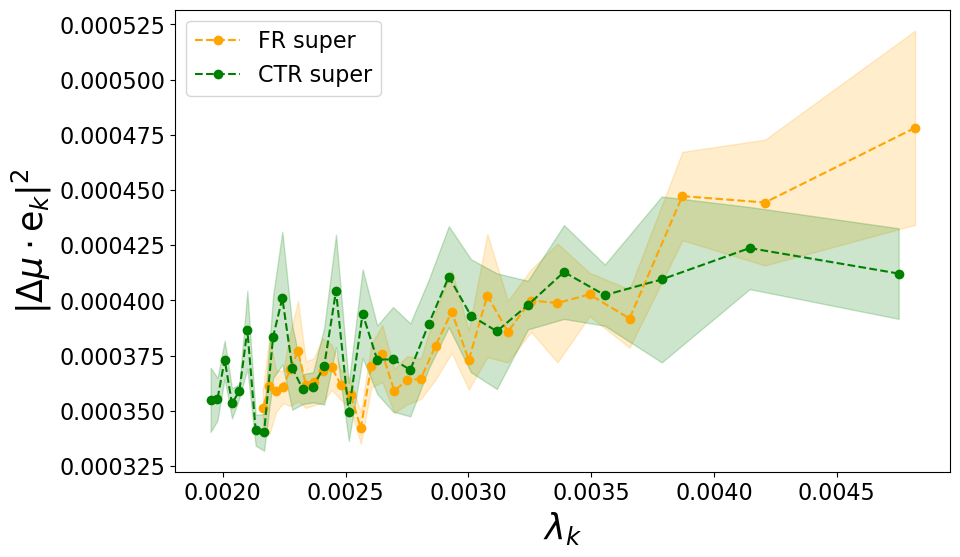

In [7]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load('../Data/overlaps_sated_food_restricted_super_5.npz')
overlaps_fr_normal = data['overlaps_fr_normal']
eigs_fr_normal = data['eigs_fr_normal']
overlaps_fr_super = data['overlaps_fr_super']
eigs_fr_super = data['eigs_fr_super']

print('overlaps_fr_normal shape:', overlaps_fr_normal.shape)
print('eigs_fr_normal shape:', eigs_fr_normal.shape)

def extract_plot_vectors(overlaps, eigs):
    total_k = eigs.shape[-1]
    n_anim = overlaps.shape[0]
    evals_plot = np.zeros((n_anim, total_k))
    dots_plot  = np.zeros((n_anim, total_k))

    for i in range(n_anim):
        evals_plot[i] = np.nanmean(eigs[i,:,:,:], axis=(0,1))
        dots_plot[i] = np.nanmean(overlaps[i,:,:,:], axis=(0,1)) # → (total_k,)

    return evals_plot, dots_plot, 

# Extract for each group
fr_evals_plot, fr_dots_plot = extract_plot_vectors(overlaps_fr_normal, eigs_fr_normal)

# Panel 1: eigenvalue size vs dot product, with across‐animal mean ± SEM
x_fr = np.nanmean(fr_evals_plot, axis=0)
y_fr = np.nanmean(fr_dots_plot, axis=0)
sem_fr = np.nanstd(fr_dots_plot, axis=0, ddof=1) / np.sqrt(fr_dots_plot.shape[0])

plt.figure(figsize=(10, 6))
# plt.plot(x_fr, y_fr, 'o--', color='red',   label='FR')
# plt.fill_between(x_fr, y_fr - sem_fr, y_fr + sem_fr, color='red',   alpha=0.2)

print('total_snr fr:', np.sum((y_fr/x_fr)))

fr_evals_plot, fr_dots_plot = extract_plot_vectors(overlaps_fr_super, eigs_fr_super)
x_fr = np.nanmean(fr_evals_plot, axis=0)
y_fr = np.nanmean(fr_dots_plot, axis=0)
sem_fr = np.nanstd(fr_dots_plot, axis=0, ddof=1) / np.sqrt(fr_dots_plot.shape[0])

plt.plot(x_fr, y_fr, 'o--', color='orange',   label='FR super')
plt.fill_between(x_fr, y_fr - sem_fr, y_fr + sem_fr, color='orange',   alpha=0.2)
print('total_snr fr super:', np.sum((y_fr/x_fr)))


data = np.load('../Data/overlaps_sated_control_super_5.npz')
overlaps_ctr_normal = data['overlaps_ctr_normal']
eigs_ctr_normal = data['eigs_ctr_normal']
overlaps_ctr_super = data['overlaps_ctr_super']
eigs_ctr_super = data['eigs_ctr_super']


# Extract for each group
ctr_evals_plot, ctr_dots_plot = extract_plot_vectors(overlaps_ctr_normal, eigs_ctr_normal)
# Panel 1: eigenvalue size vs dot product, with across‐animal mean ± SEM
x_ctr = np.nanmean(ctr_evals_plot, axis=0)
y_ctr = np.nanmean(ctr_dots_plot, axis=0)
sem_ctr = np.nanstd(ctr_dots_plot, axis=0, ddof=1) / np.sqrt(ctr_dots_plot.shape[0])
# plt.plot(x_ctr, y_ctr, 'o--', color='blue', label='CTR ')
# plt.fill_between(x_ctr, y_ctr - sem_ctr, y_ctr + sem_ctr, color='blue', alpha=0.2) 
print('total_snr ctr:', np.sum((y_ctr/x_ctr)))
     
# Extract for each group
ctr_evals_plot, ctr_dots_plot = extract_plot_vectors(overlaps_ctr_super, eigs_ctr_super)
x_ctr = np.nanmean(ctr_evals_plot, axis=0)
y_ctr = np.nanmean(ctr_dots_plot, axis=0)
sem_ctr = np.nanstd(ctr_dots_plot, axis=0, ddof=1) / np.sqrt(ctr_dots_plot.shape[0])
plt.plot(x_ctr, y_ctr, 'o--', color='green', label='CTR super')
plt.fill_between(x_ctr, y_ctr - sem_ctr, y_ctr + sem_ctr, color='green', alpha=0.2) 
print('total_snr ctr super:', np.sum((y_ctr/x_ctr)))




plt.xlabel(r'$\lambda_k$',fontsize = 25)
plt.ylabel(r'$|\Delta \mu \cdot \text{e}_k|^2$',fontsize = 25)
# plt.ylabel(r'$\cos^2(\theta_k)$', fontsize = 25)
plt.legend(fontsize =16, loc='upper left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('eigenvalue_dot_product.svg',bbox_inches='tight')